In [1]:
import pandas as pd

nov_merged = pd.read_csv('../DATASET/obs_est_merged/nov_merged.csv')

C:\Users\DataScience\AppData\Local\Temp\ipykernel_18960\2877605712.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
nov_merged

,lat,lon,year,month,precip_est,precip_obs,bias_nov
0,45.0,-20.0,1981,12,107.417970,131.149290,-23.731320
1,45.0,-19.0,1981,12,98.339840,126.678470,-28.338630
2,45.0,-18.0,1981,12,92.800780,122.924805,-30.124025
3,45.0,-17.0,1981,12,88.367190,139.038090,-50.670900
4,45.0,-16.0,1981,12,85.582030,123.603820,-38.021790
...,...,...,...,...,...,...,...
230251,20.0,16.0,2017,5,1.878309,0.118256,1.760054
230252,20.0,17.0,2017,5,1.065809,0.591278,0.474531
230253,20.0,18.0,2017,5,1.386122,0.591278,0.794844
230254,20.0,19.0,2017,5,1.241591,1.182556,0.059034


In [3]:
nov_merged = nov_merged.drop(columns=['year', 'bias_nov'])

In [4]:
nov_average= nov_merged.groupby(['month', 'lat', 'lon']).agg({'precip_est': 'mean', 'precip_obs': 'mean'}).reset_index()
nov_average['is_train'] = nov_average['month'].apply(lambda x: x in [12, 1, 2])  # temporary splitting

In [5]:
nov_average

,month,lat,lon,precip_est,precip_obs,is_train
0,1,20.0,-20.0,3.645733,2.457407,True
1,1,20.0,-19.0,2.946839,2.952894,True
2,1,20.0,-18.0,2.271275,2.349642,True
3,1,20.0,-17.0,1.920906,2.645599,True
4,1,20.0,-16.0,1.758146,3.575113,True
...,...,...,...,...,...,...
6391,12,45.0,16.0,103.410651,79.106119,True
6392,12,45.0,17.0,86.551385,67.010138,True
6393,12,45.0,18.0,67.465773,58.495204,True
6394,12,45.0,19.0,59.658373,50.671153,True


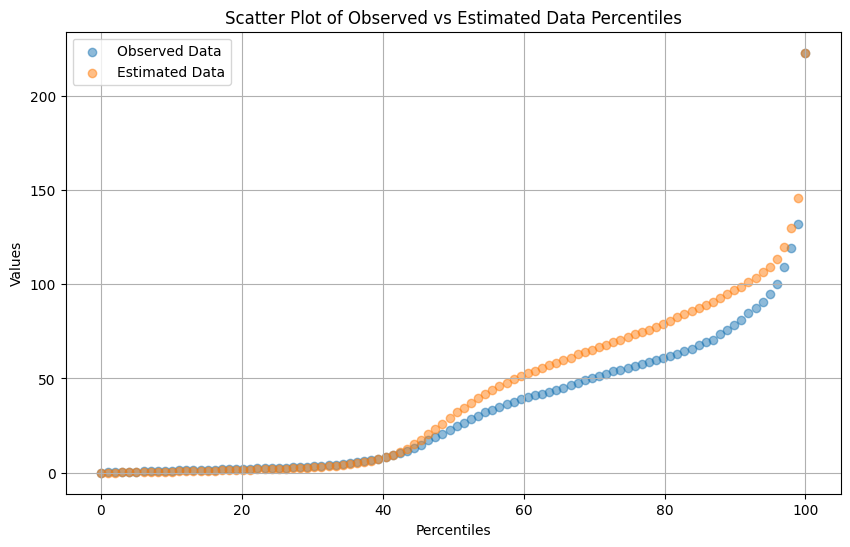

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume we have two numpy arrays of data: observed and estimated
# For the sake of example, I'll generate some random data to represent this
# np.random.seed(42)
observed_data = nov_average[nov_average['is_train'] == True]['precip_obs']  # ref_data_ast
estimated_data = nov_average[nov_average['is_train'] == True]['precip_est']  # estimated_past

# Calculate the percentiles
percentiles = np.linspace(0, 100, 100)  # 100 percentiles from 0 to 100
observed_percentiles = np.percentile(observed_data, percentiles)
estimated_percentiles = np.percentile(estimated_data, percentiles)

plt.figure(figsize=(10, 6))
plt.scatter(percentiles, observed_percentiles, alpha=0.5, label='Observed Data')
plt.scatter(percentiles, estimated_percentiles, alpha=0.5, label='Estimated Data')

plt.title('Scatter Plot of Observed vs Estimated Data Percentiles')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

## We have an over estimation generally!!

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore

def eQM_porcentual_delta(ref_dataset, model_present, model_future, hyper):
    """
    Remove biases for each quantile value by calculating the difference between
    ref_dataset and model_present at each percentile as a systematic bias (delta)
    and then apply this same delta to model_future at the corresponding percentile.
    """
   
    model_present_corrected = np.zeros(model_present.size)  
    model_future_corrected = np.zeros(model_future.size)

    # Ensure model values are never zero to avoid division by zero
    epsilon = 1e-10  # A small number to prevent division by zero
    model_present_safe = np.where(model_present == 0, epsilon, model_present)
    model_future_safe = np.where(model_future == 0, epsilon, model_future)

    for ival, model_value in enumerate(model_present_safe):
        percentile = percentileofscore(model_present_safe, model_value)
        percentile_ref = np.percentile(ref_dataset, percentile)
        dif = (percentile_ref - model_value) / model_value
        model_present_corrected[ival] = model_value * (1 + dif)
        model_future_corrected[ival] = model_future_safe[ival] * (1 + hyper * dif)
            
    return model_present_corrected, model_future_corrected

In [8]:
# Applying the correction
nov_average['corrected_precip_est'] = 0  # Initialize the column for corrected estimates

# Separate the datasets
is_train = nov_average['is_train']
ref_dataset = nov_average[is_train]['precip_obs']
model_present = nov_average[is_train]['precip_est']
model_future = nov_average[~is_train]['precip_est']

best_rmse = np.inf  # Initialize the best RMSE with a very large number
best_hyper = None 

for hyper in np.arange(0, 3.1, 0.1):  # Loop from 0 to 3 with a step of 0.1
    model_present_corrected, model_future_corrected = eQM_porcentual_delta(ref_dataset, model_present, model_future, hyper)

    # Correct the DataFrame
    nov_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected
    nov_average.loc[~is_train, 'corrected_precip_est'] = model_future_corrected

    test_data = nov_average[~is_train]  # Simpler way to filter out test data
    rmse = np.sqrt(np.mean((test_data['corrected_precip_est'] - test_data['precip_obs'])**2))

    if rmse < best_rmse:
        best_rmse = rmse
        best_hyper = hyper

    # Print RMSE for each iteration (optional)
    print(f"Hyperparameter: {hyper:.1f}, RMSE: {rmse}")

# After all iterations, print the best RMSE found
print(f"Best Hyperparameter: {best_hyper:.1f}, Best RMSE: {best_rmse}")

C:\Users\DataScience\AppData\Local\Temp\ipykernel_18960\2641046764.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 4.09158327  3.47257626  2.86631273 ... 52.00395735 45.0617288
 38.91716637]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  nov_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected


Hyperparameter: 0.0, RMSE: 17.624874575383114
Hyperparameter: 0.1, RMSE: 17.204161641501067
Hyperparameter: 0.2, RMSE: 16.813226696103207
Hyperparameter: 0.3, RMSE: 16.454192360640757
Hyperparameter: 0.4, RMSE: 16.12918909015981
Hyperparameter: 0.5, RMSE: 15.840311718209392
Hyperparameter: 0.6, RMSE: 15.589568631386301
Hyperparameter: 0.7, RMSE: 15.378825216970116
Hyperparameter: 0.8, RMSE: 15.209744250127228
Hyperparameter: 0.9, RMSE: 15.08372684097637
Hyperparameter: 1.0, RMSE: 15.001858245925867
Hyperparameter: 1.1, RMSE: 14.964863060090696
Hyperparameter: 1.2, RMSE: 14.973073904259957
Hyperparameter: 1.3, RMSE: 15.026416673190724
Hyperparameter: 1.4, RMSE: 15.124413842824062
Hyperparameter: 1.5, RMSE: 15.266205497779149
Hyperparameter: 1.6, RMSE: 15.450585965282572
Hyperparameter: 1.7, RMSE: 15.676052538809042
Hyperparameter: 1.8, RMSE: 15.940861955589678
Hyperparameter: 1.9, RMSE: 16.24309012268237
Hyperparameter: 2.0, RMSE: 16.58069099099151
Hyperparameter: 2.1, RMSE: 16.95155128

In [15]:
# Applying the correction
nov_average['corrected_precip_est'] = 0  # Initialize the column for corrected estimates

# Separate the datasets
is_train = nov_average['is_train']
ref_dataset = nov_average[is_train]['precip_obs']
model_present = nov_average[is_train]['precip_est']
model_future = nov_average[~is_train]['precip_est']

model_present_corrected, model_future_corrected = eQM_porcentual_delta(ref_dataset, model_present, model_future, 1.1)

# Correct the DataFrame
nov_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected
nov_average.loc[~is_train, 'corrected_precip_est'] = model_future_corrected

test_data = nov_average[nov_average['is_train'] == False]
nov_average.loc[test_data.index, 'RMSE'] = np.sqrt((test_data['corrected_precip_est'] - test_data['precip_obs'])**2)

# mean_squared_error = nov_average['RMSE'].mean()

# Step 3: Calculate the Global RMSE
global_rmse = np.sqrt(np.mean((test_data['corrected_precip_est'] - test_data['precip_obs'])**2))

print("Global RMSE:", global_rmse)

Global RMSE: 14.964863060090696


C:\Users\DataScience\AppData\Local\Temp\ipykernel_18960\3972467577.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 4.09158327  3.47257626  2.86631273 ... 52.00395735 45.0617288
 38.91716637]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  nov_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected


In [16]:
nov_average.dtypes

month                     int64
lat                     float64
lon                     float64
precip_est              float64
precip_obs              float64
is_train                   bool
corrected_precip_est    float64
RMSE                    float64
dtype: object

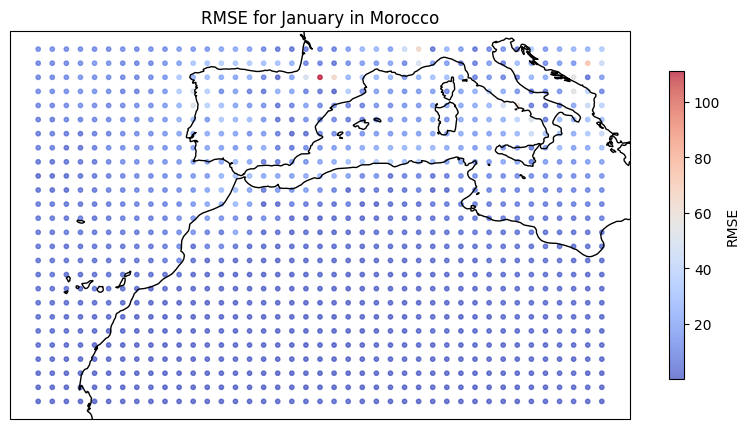

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns

# Load your data into a DataFrame.
df = nov_average

# Filter the DataFrame for January and is_train == False.
january_test_df = df[df['month'] == 5]

# Create a scatter plot using plt.scatter for the lat/lon with the color intensity based on the RMSE.
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# You might want to adjust the extent to frame Morocco properly
# ax.set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])

scatter = ax.scatter(january_test_df['lon'], january_test_df['lat'], 
                     c=january_test_df['RMSE'], cmap='coolwarm', 
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

plt.colorbar(scatter, shrink=0.5, label='RMSE')
plt.title('RMSE for January in Morocco')
plt.show()

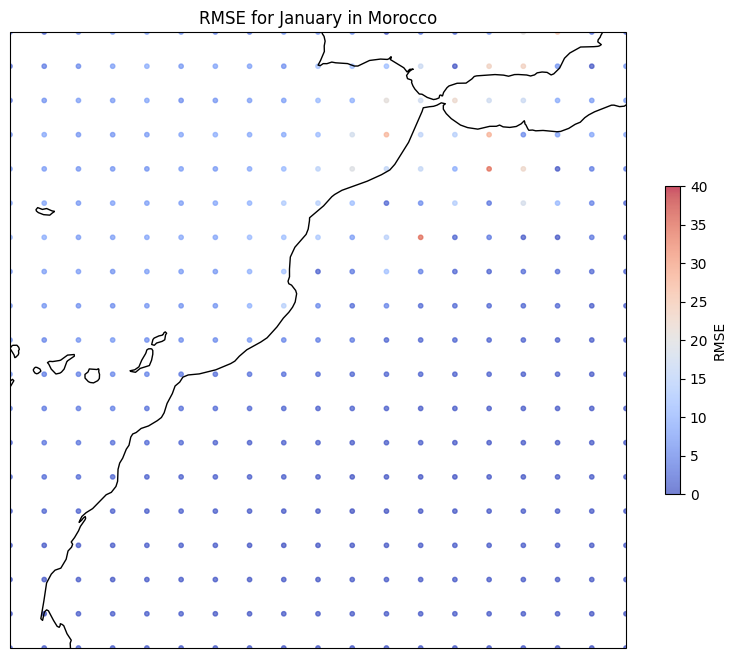

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# Load your data into a DataFrame.
df = nov_average  # Make sure 'nov_average' is defined and contains your data.

# Filter the DataFrame for January and is_train == False.
january_test_df = df[(df['month'] == 4) & (df['is_train'] == False)]

# Start by setting up the figure and axes with the desired size and projection.
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the map to frame Morocco properly.
# This should come before plotting the scatter plot to avoid any overlay issues.
ax.set_extent([-18, 0, 20, 38])

# Add the coastlines to the map for reference.
ax.coastlines()

scatter = ax.scatter(january_test_df['lon'], january_test_df['lat'], 
                     c=january_test_df['RMSE'], cmap='coolwarm', vmin=0, vmax=40,
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

plt.colorbar(scatter, shrink=0.5, label='RMSE')
plt.title('RMSE for January in Morocco')
plt.show()

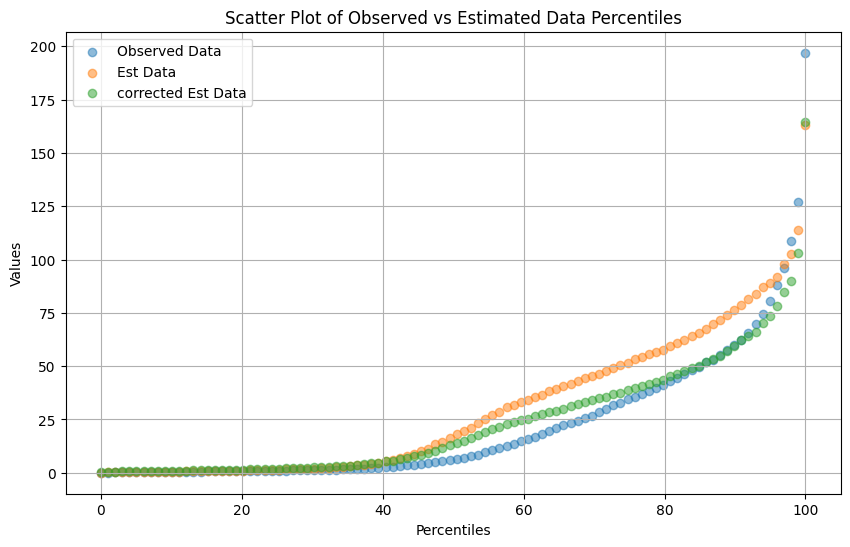

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume we have two numpy arrays of data: observed and estimated
# For the sake of example, I'll generate some random data to represent this
# np.random.seed(42)
observed_data = nov_average[nov_average['is_train'] == False]['precip_obs']
estimated_data = nov_average[nov_average['is_train'] == False]['precip_est']
corrected_estimated_data = nov_average[nov_average['is_train'] == False]['corrected_precip_est']


# Calculate the percentiles
percentiles = np.linspace(0, 100, 100)  # 100 percentiles from 0 to 100
observed_percentiles = np.percentile(observed_data, percentiles)
estimated_percentiles = np.percentile(estimated_data, percentiles)
corrected_estimated_percentiles = np.percentile(corrected_estimated_data, percentiles)

plt.figure(figsize=(10, 6))
plt.scatter(percentiles, observed_percentiles, alpha=0.5, label='Observed Data')
plt.scatter(percentiles, estimated_percentiles, alpha=0.5, label='Est Data')
plt.scatter(percentiles, corrected_estimated_percentiles, alpha=0.5, label='corrected Est Data')


plt.title('Scatter Plot of Observed vs Estimated Data Percentiles')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

## We have an under isitimation generally!!

In [20]:
nov_average

,month,lat,lon,precip_est,precip_obs,is_train,corrected_precip_est,RMSE
0,1,20.0,-20.0,3.645733,2.457407,True,4.091583,NaN
1,1,20.0,-19.0,2.946839,2.952894,True,3.472576,NaN
2,1,20.0,-18.0,2.271275,2.349642,True,2.866313,NaN
3,1,20.0,-17.0,1.920906,2.645599,True,2.481128,NaN
4,1,20.0,-16.0,1.758146,3.575113,True,2.294113,NaN
...,...,...,...,...,...,...,...,...
6391,12,45.0,16.0,103.410651,79.106119,True,87.536992,NaN
6392,12,45.0,17.0,86.551385,67.010138,True,66.503816,NaN
6393,12,45.0,18.0,67.465773,58.495204,True,52.003957,NaN
6394,12,45.0,19.0,59.658373,50.671153,True,45.061729,NaN


In [21]:
nov_avecoef_rmse = nov_average[nov_average['is_train'] == False].groupby('month')['RMSE'].mean()

nov_avecoef_rmse.to_csv('../DATASET/for_heatmap/nov_avecoef_rmse.csv', header=True)